# 1. 데이터 로드 및 단어 토큰화

In [ ]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있습니다. 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠습니다. 전체 문장 샘플의 개수를 확인합니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7f59fc37feb0>)

In [ ]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.
     

In [ ]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


첫번째 샘플만 출력해보겠습니다.



In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 pos_tags에 저장하였습니다. 첫번째 문장 샘플을 출력해보겠습니다.



In [ ]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서 sentences[0]에, 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당됩니다. 임의로 8번 인덱스 샘플에 대해서도 확인해보겠습니다.

In [ ]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 이제 훈련 데이터와 테스트 데이터를 분리해봅시다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=.2, random_state=777)

학습이 진행되는 동안 성능을 확인하기 위한 검증 데이터 또한 분리합니다.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=777)

학습 데이터, 검증 데이터, 테스트 데이터의 개수는 다음과 같습니다.

In [ ]:
print('훈련 데이터의 개수 :', len(X_train))
print('검증 데이터의 개수 :', len(X_valid))
print('테스트 데이터의 개수 :', len(X_test))
print('훈련 데이터 레이블의 개수 :', len(X_train))
print('검증 데이터 레이블의 개수 :', len(X_valid))
print('테스트 데이터 레이블의 개수 :', len(X_test))

훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2809
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2809


학습 데이터의 상위 2개 샘플만 출력해봅시다. 현재 데이터는 단어 토큰화가 된 상태입니다.

In [ ]:
# 상위 샘플 2개 출력
for sent in X_train[:2]:
  print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


# 2. Vocab 만들기

단어 집합을 만들어봅시다. 각 단어의 등장 빈도를 카운트해주는 Counter를 사용하여 각 단어별 빈도수를 기록합니다. 이렇게 기록된 단어의 총 종류를 출력하여 총 단어수를 확인해봅시다.

In [ ]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 16742


단어수는 16,742개입니다. 임의로 영단어 the와 love의 등장횟수를 확인해보겠습니다.

In [ ]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 5410
훈련 데이터에서의 단어 love의 등장 횟수 : 7


영단어 the의 등장 횟수는 5,410회이며, 영단어 love의 등장 횟수는 7회입니다.

word_counts를 정렬하고 등장 빈도 상위 10개 단어를 출력해봅시다.

In [ ]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


이제 단어 집합을 만들기 위해서 패딩을 위한 토큰, 그리고 OOV 문제(Out-Of-Vocabulary) 발생 시에 사용하는 UNK 토큰을 위한 정수 0과 1을 각각 단어 집합에 할당합니다.

In [ ]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [ ]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [ ]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 16744


In [ ]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 the와 맵핑되는 정수 :', word_to_index['the'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 the와 맵핑되는 정수 : 2


# 3. 정수 인코딩

텍스트를 정수로 변환해주는 함수를 만듭니다. 해당 함수는 OOV 문제가 발생할 경우 해당 단어는`<UNK>` 토큰과 맵핑되는 정수인 1로 변환합니다.

In [ ]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [ ]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [ ]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[1260, 3215, 117, 17, 21, 123, 56, 539, 23]
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]


In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [ ]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
복원된 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


In [ ]:
# y_train으로부터 존재하는 모든 태그들의 집합 구하기
flatten_tags = [tag for sent in y_train for tag in sent]
tag_vocab = list(set(flatten_tags))
print('태그 집합 :', tag_vocab)
print('태그 집합의 크기 :', len(tag_vocab))

태그 집합 : ['B-PER', 'I-MISC', 'B-ORG', 'I-PER', 'B-LOC', 'I-LOC', 'I-ORG', 'O', 'B-MISC']
태그 집합의 크기 : 9


In [ ]:
tag_to_index = {}
tag_to_index['<PAD>'] = 0

for index, word in enumerate(tag_vocab) :
  tag_to_index[word] = index + 1

tag_vocab_size = len(tag_to_index)
# print('패딩 토큰까지 포함된 태그 집합의 크기 :', tag_vocab_size)
print('태그 집합 :', tag_to_index)

태그 집합 : {'<PAD>': 0, 'B-PER': 1, 'I-MISC': 2, 'B-ORG': 3, 'I-PER': 4, 'B-LOC': 5, 'I-LOC': 6, 'I-ORG': 7, 'O': 8, 'B-MISC': 9}


many-to-many 문제의 경우에는 레이블도 시퀀스 데이터가 되므로 각 레이블을 정수 시퀀스로 변환해줍니다.

In [ ]:
def encoding_label(sequence, tag_to_index):
  label_sequence = []
  for seq in sequence:
    label_sequence.append([tag_to_index[tag] for tag in seq])
  return label_sequence

In [ ]:
encoded_y_train = encoding_label(y_train, tag_to_index)
encoded_y_valid = encoding_label(y_valid, tag_to_index)
encoded_y_test = encoding_label(y_test, tag_to_index)

In [ ]:
print('X 데이터 상위 2개')
print(encoded_X_train[:2])
print('-' * 50)
print('y 데이터 상위 2개')
print(encoded_y_train[:2])
print('-' * 50)
print('첫번째 샘플과 레이블의 길이')
print(len(encoded_X_train[0]))
print(len(encoded_y_train[0]))

X 데이터 상위 2개
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]
--------------------------------------------------
y 데이터 상위 2개
[[3, 7, 8, 8, 8, 8, 8, 8, 8], [1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]
--------------------------------------------------
첫번째 샘플과 레이블의 길이
9
9


# 4. 패딩

샘플의 최대 길이 : 78
샘플의 평균 길이 : 14.518420


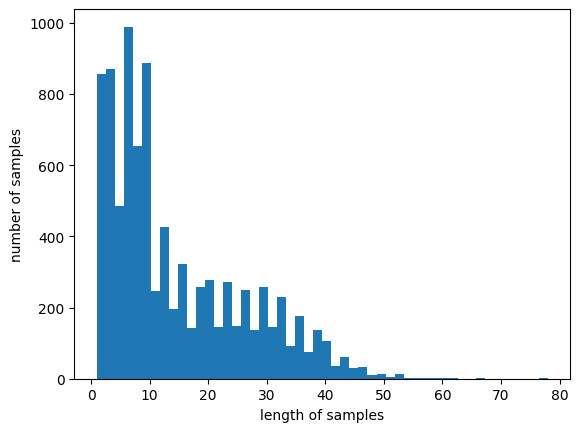

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in encoded_X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_X_train))/len(encoded_X_train)))
plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 샘플의 길이는 78이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 50내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 encoded_X_train과 encoded_X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

사실 최대 길이가 78이므로 78로 패딩해도 됩니다. 여기서는 80정도로 패딩해보겠습니다.

In [ ]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [ ]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [ ]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

In [ ]:
print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)
print('-' * 30)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)

훈련 데이터의 크기 : (8985, 80)
검증 데이터의 크기 : (2247, 80)
테스트 데이터의 크기 : (2809, 80)
------------------------------
훈련 데이터의 레이블 : (8985, 80)
검증 데이터의 레이블 : (2247, 80)
테스트 데이터의 레이블 : (2809, 80)


패딩 후의 데이터를 확인해보겠습니다.

In [ ]:
print('훈련 데이터의 상위 샘플 2개')
print(padded_X_train[:2])
print('-' * 5 + '레이블' + '-' * 5)
print(padded_y_train[:2])

훈련 데이터의 상위 샘플 2개
[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
-----레이블-----
[[3 7 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# 5. 모델링

이제 모델링을 해봅시다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


GRU 사용 시 코드는 다음과 같습니다.

```
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)
        logits = self.fc(gru_out)  # (batch_size, seq_length, output_dim)
        return logits
```

품사 태깅을 수행하는 코드에서 GRU를 Bidirectional LSTM 2층짜리로 변경하려면 다음과 같이 수정하면 됩니다:

In [ ]:
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim*2)
        logits = self.fc(lstm_out)  # (batch_size, seq_length, output_dim)
        return logits

이 수정에서는 다음과 같은 변경사항이 있습니다:

1. nn.GRU를 nn.LSTM으로 변경했습니다.
2. num_layers 매개변수를 추가하고 이를 nn.LSTM 생성자에 전달했습니다. 기본값은 2입니다.
3. bidirectional=True를 추가하여 양방향 LSTM을 사용하도록 설정했습니다.
4. nn.Linear의 입력 차원을 hidden_dim*2로 변경하여 양방향 LSTM의 출력을 처리하도록 했습니다.

In [ ]:
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [ ]:
print(vocab_size)

16744


In [ ]:
embedding_dim = 100
hidden_dim = 256
output_dim = tag_vocab_size
learning_rate = 0.01
num_epochs = 10
num_layers = 2

In [ ]:
# Model, loss, optimizer
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

NERTagger(
  (embedding): Embedding(16744, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

앞으로 많이 사용하게 될 비용함수인 nn.CrossEntropyLoss에서는 ignore_index를 통해서 특정 인덱스에 대한 loss를 구하지 않을 수 있습니다.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def calculate_accuracy(logits, labels, ignore_index=0):
    # 예측 레이블을 구합니다.
    predicted = torch.argmax(logits, dim=1)

    # 패딩 토큰은 무시합니다.
    mask = (labels != ignore_index)

    # 정답을 맞춘 경우를 집계합니다.
    correct = (predicted == labels).masked_select(mask).sum().item()
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            logits = model(batch_X)

            # Compute loss
            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

            # Calculate validation accuracy and loss
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

학습하는 동안 훈련 데이터의 정확도와 손실, 검증 데이터의 정확도와 손실을 지속적으로 확인합니다. 그리고 검증 데이터의 손실이 지금까지 중 가장 최소가 되는 시점마다 모델을 저장하여 결과적으로 검증 데이터 손실이 학습하는 도중 가장 최소일 때의 Best 모델을 저장합니다.

In [ ]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/10:
Train Loss: 0.3921, Train Accuracy: 0.8912
Validation Loss: 0.2122, Validation Accuracy: 0.9395
Validation loss improved from inf to 0.2122. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.1203, Train Accuracy: 0.9643
Validation Loss: 0.1709, Validation Accuracy: 0.9513
Validation loss improved from 0.2122 to 0.1709. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.0491, Train Accuracy: 0.9852
Validation Loss: 0.1606, Validation Accuracy: 0.9560
Validation loss improved from 0.1709 to 0.1606. 체크포인트를 저장합니다.
Epoch 4/10:
Train Loss: 0.0261, Train Accuracy: 0.9920
Validation Loss: 0.1749, Validation Accuracy: 0.9573
Epoch 5/10:
Train Loss: 0.0203, Train Accuracy: 0.9938
Validation Loss: 0.2250, Validation Accuracy: 0.9478
Epoch 6/10:
Train Loss: 0.0202, Train Accuracy: 0.9936
Validation Loss: 0.1997, Validation Accuracy: 0.9537
Epoch 7/10:
Train Loss: 0.0232, Train Accuracy: 0.9923
Validation Loss: 0.2072, Validation Accuracy: 0.9530
Epoch 8/10:
Train Loss: 0.0222, Train Accuracy: 0.9929
Valida

# 6. 모델 로드 및 평가

위에서 저장해둔 Best 모델을 로드하여 정상 로드되었는지 확인하기 위해서 검증 데이터에 대한 정확도와 손실을 출력하고, 테스트 데이터에 대해서도 평가를 진행합니다.

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.1606
Best model validation accuracy: 0.9560


In [ ]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.1609
Best model test accuracy: 0.9566


# 7. 인퍼런스(테스트)

모델을 서비스에 적용하게 되면 전처리가 전혀 되어있지 않은 임의의 텍스트 입력에 대해서 동작해야 할 것입니다. 임의의 텍스트 입력에 대해서 예측 레이블을 리턴하는 함수를 만들어봅시다.

In [ ]:
index_to_tag = {}
for key, value in tag_to_index.items():
    index_to_tag[value] = key

In [ ]:
def predict_labels(text, model, word_to_ix, index_to_tag, max_len=150):
    # 단어 토큰화
    tokens = text.split()

    # 정수 인코딩
    token_indices = [word_to_ix.get(token, 1) for token in tokens]

    # 패딩
    token_indices_padded = np.zeros(max_len, dtype=int)
    token_indices_padded[:len(token_indices)] = token_indices[:max_len]

    # 텐서로 변환
    input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

    # 모델의 입력으로 사용하고 예측값 리턴
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)

    # 가장 값이 높은 인덱스를 예측값으로 선택
    predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    # 패딩 토큰 제거
    predicted_indices_no_pad = predicted_indices[:len(tokens)]

    # 패딩 토큰을 제외하고 정수 시퀀스를 예측 시퀀스로 변환
    predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

    return predicted_tags

학습에 사용되지 않은 테스트 데이터의 첫번째 샘플을 이용해봅시다. 현재 이 데이터는 이미 단어 토큰화가 된 상태라서 단어 토큰화 이전 상태로 되돌려 전처리가 전혀 되어있지 않은 입력을 가정하고 함수에 입력으로 사용하겠습니다.

In [ ]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


In [ ]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


In [ ]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('예측 :', predicted_tags)
print('실제값 :', y_test[0])

예측 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O']
실제값 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
